In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
from torch.utils.data import  DataLoader
from torchvision import datasets, transforms

In [3]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

## Import model

In [4]:
transform = transforms.ToTensor()

In [5]:
train_data = datasets.MNIST(root='../Data',train=True,download=True,transform =  transform)

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ../Data/MNIST/raw/train-images-idx3-ubyte.gz to ../Data/MNIST/raw




Extracting ../Data/MNIST/raw/train-labels-idx1-ubyte.gz to ../Data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ../Data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../Data/MNIST/raw




Extracting ../Data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../Data/MNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [6]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: ../Data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [7]:
test_data = datasets.MNIST(root='../Data',train=False,download=True,transform =  transform)

In [8]:
test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: ../Data
    Split: Test
    StandardTransform
Transform: ToTensor()

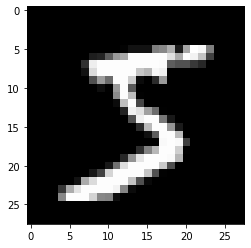

In [9]:
plt.imshow(train_data[0][0].reshape(28,28),cmap='gray')

In [11]:
image,label = train_data[0]
print('Shape:', image.shape,'\nLabel:',label)

Shape: torch.Size([1, 28, 28]) 
Label: 5


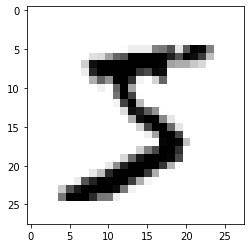

In [12]:
plt.imshow(train_data[0][0].reshape(28,28),cmap='gist_yarg')

In [13]:
torch.manual_seed(101)

train_loader = DataLoader(train_data,batch_size=100,shuffle=True)
test_loader = DataLoader(test_data,batch_size=500,shuffle=True)

Labels:  [   4    6    2    3    4    0    9    5    0    1    6    9]


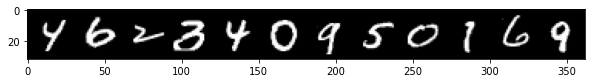

In [14]:
from torchvision.utils import make_grid
np.set_printoptions(formatter=dict(int=lambda x: f'{x:4}')) # to widen the printed array

# Grab the first batch of images
for images,labels in train_loader: 
    break

# Print the first 12 labels
print('Labels: ', labels[:12].numpy())

# Print the first 12 images
im = make_grid(images[:12], nrow=12)  # the default nrow is 8
plt.figure(figsize=(10,4))
# We need to transpose the images from CWH to WHC
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));

In [24]:
class MLP(nn.Module):
  def __init__(self,in_size=784,out_sz = 10, layers=[120,84]):
    super().__init__()
    self.fc1 = nn.Linear(in_size,layers[0])
    self.fc2 = nn.Linear(layers[0],layers[1])
    self.fc3 = nn.Linear(layers[1],out_sz)
  def forward(self,X):
    X = F.relu(self.fc1(X))
    X = F.relu(self.fc2(X))
    X = self.fc3(X)
    return F.log_softmax(X,dim=1)

In [25]:
torch.manual_seed(101)
model = MLP()
model

MLP(
  (fc1): Linear(in_features=784, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [26]:
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')

In [27]:
count_parameters(model)

 94080
   120
 10080
    84
   840
    10
______
105214


In [28]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [29]:
# Load the first batch, print its shape
for images, labels in train_loader:
    print('Batch shape:', images.size())
    break
    
# EQUIVALENT TO:
# dataiter = iter(train_loader)
# images, labels = dataiter.next()
# print('Batch shape:', images.size())

Batch shape: torch.Size([100, 1, 28, 28])


In [30]:
images.view(100,-1).size()

torch.Size([100, 784])

In [31]:
import time
start_time = time.time()

epochs = 10
train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0
    
    # Run the training batches
    for b, (X_train, y_train) in enumerate(train_loader):
        b+=1
        
        # Apply the model
        y_pred = model(X_train.view(100, -1))  # Here we flatten X_train
        loss = criterion(y_pred, y_train)
 
        # Tally the number of correct predictions
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr
        
        # Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Print interim results
        if b%200 == 0:
            print(f'epoch: {i:2}  batch: {b:4} [{100*b:6}/60000]  loss: {loss.item():10.8f}  \
accuracy: {trn_corr.item()*100/(100*b):7.3f}%')
    
    # Update train loss & accuracy for the epoch
    train_losses.append(loss)
    train_correct.append(trn_corr)
        
    # Run the testing batches
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):

            # Apply the model
            y_val = model(X_test.view(500, -1))  # Here we flatten X_test

            # Tally the number of correct predictions
            predicted = torch.max(y_val.data, 1)[1] 
            tst_corr += (predicted == y_test).sum()
    
    # Update test loss & accuracy for the epoch
    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)
        
print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed            

epoch:  0  batch:  200 [ 20000/60000]  loss: 0.30717614  accuracy:  83.795%
epoch:  0  batch:  400 [ 40000/60000]  loss: 0.15741336  accuracy:  88.095%
epoch:  0  batch:  600 [ 60000/60000]  loss: 0.22855240  accuracy:  89.947%
epoch:  1  batch:  200 [ 20000/60000]  loss: 0.20674856  accuracy:  95.050%
epoch:  1  batch:  400 [ 40000/60000]  loss: 0.14258276  accuracy:  95.252%
epoch:  1  batch:  600 [ 60000/60000]  loss: 0.22368401  accuracy:  95.460%
epoch:  2  batch:  200 [ 20000/60000]  loss: 0.21219878  accuracy:  96.885%
epoch:  2  batch:  400 [ 40000/60000]  loss: 0.12101877  accuracy:  96.808%
epoch:  2  batch:  600 [ 60000/60000]  loss: 0.07449820  accuracy:  96.838%
epoch:  3  batch:  200 [ 20000/60000]  loss: 0.03288248  accuracy:  97.725%
epoch:  3  batch:  400 [ 40000/60000]  loss: 0.20596203  accuracy:  97.593%
epoch:  3  batch:  600 [ 60000/60000]  loss: 0.06838793  accuracy:  97.588%
epoch:  4  batch:  200 [ 20000/60000]  loss: 0.06533995  accuracy:  98.285%
epoch:  4  b

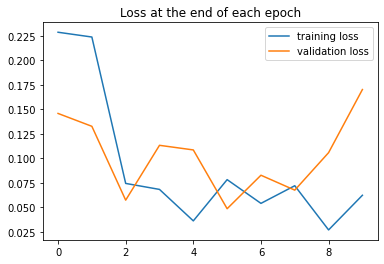

In [32]:
plt.plot(train_losses, label='training loss')
plt.plot(test_losses, label='validation loss')
plt.title('Loss at the end of each epoch')
plt.legend();

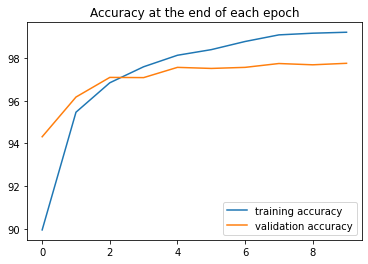

In [33]:
plt.plot([t/600 for t in train_correct], label='training accuracy')
plt.plot([t/100 for t in test_correct], label='validation accuracy')
plt.title('Accuracy at the end of each epoch')
plt.legend();

In [34]:
print(test_correct) # contains the results of all 10 epochs
print()
print(f'Test accuracy: {test_correct[-1].item()*100/10000:.3f}%') # print the most recent result as a percent

[tensor(9431), tensor(9617), tensor(9709), tensor(9708), tensor(9756), tensor(9751), tensor(9756), tensor(9774), tensor(9768), tensor(9775)]

Test accuracy: 97.750%


In [35]:
# Extract the data all at once, not in batches
test_load_all = DataLoader(test_data, batch_size=10000, shuffle=False)

In [36]:
with torch.no_grad():
    correct = 0
    for X_test, y_test in test_load_all:
        y_val = model(X_test.view(len(X_test), -1))  # pass in a flattened view of X_test
        predicted = torch.max(y_val,1)[1]
        correct += (predicted == y_test).sum()
print(f'Test accuracy: {correct.item()}/{len(test_data)} = {correct.item()*100/(len(test_data)):7.3f}%')

Test accuracy: 9775/10000 =  97.750%


In [38]:
y_eval = model.forward(X_test.view(-1,784))

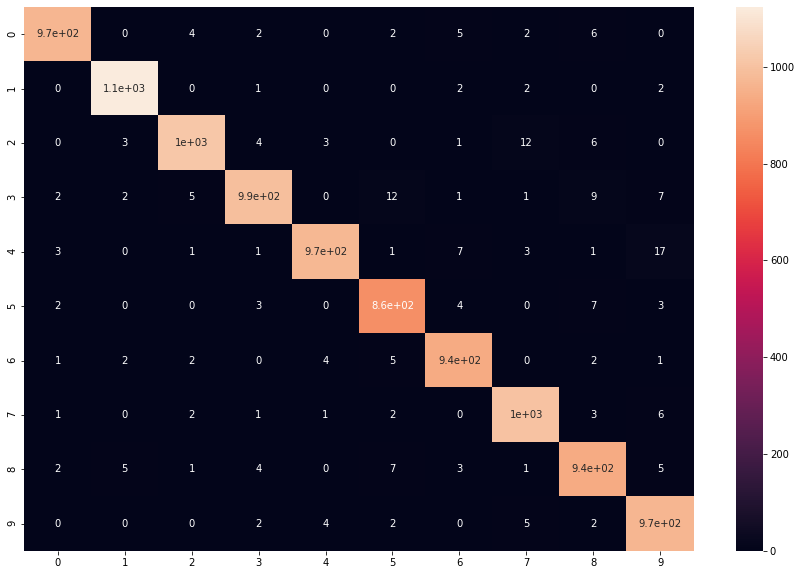

In [44]:
import seaborn as sns

plt.figure(figsize=(15,10))
sns.heatmap(confusion_matrix(y_eval.argmax(1),y_test),annot=True)